# Ensemble Methods 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve

## Goal 
- Explore two ensemble methods: AdaBoost and Random Forests 
- Use key performance indicators (KPIs) appropriate for highly skewed data 
- Characterize model performance with ROC curves

## Load Data 
This dataset contains transactions made by credit cards in September 2013 by european cardholders. The dataset is highly unbalanced, the positive class (frauds) account for 0.17% of all transactions. The data is already PCA transformed. 

In [2]:
df_cc = pd.read_csv('https://www.cs.utexas.edu/~chaney/cc.csv')

## Partition Data for Cross Validation 
Using a stratified k-fold to preserve the class balance so our target class is not underrepresented in any k-fold selection. 

Using k = 3 

   - `d_train_df_X` : where the key is the fold number, and the value is the attribute training dataframe at that fold
   - `d_test_df_X`  : where the key is the fold number, and the value is the attribute test dataframe at that fold
   - `d_train_s_y`  : where the key is the fold number, and the value is the target training series at that fold
   - `d_train_s_y`  : where the key is the fold number, and the value is the target test series at that fold

In [3]:
df_X = df_cc.drop(columns=['Class'])
s_y = df_cc['Class']
skf = StratifiedKFold(n_splits=3,shuffle=True,random_state=23)
d_train_df_X = dict()
d_test_df_X = dict()
d_train_s_y = dict()
d_test_s_y = dict()

idxs = skf.split(df_X, s_y)

foldNum = 0
for train, test in idxs:
    train_X = df_X.iloc[train]
    test_X = df_X.iloc[test]
    train_y = s_y.iloc[train]
    test_y = s_y.iloc[test]
    
    d_train_df_X[foldNum] = df_X.iloc[train]
    d_test_df_X[foldNum] = df_X.iloc[test]
    d_train_s_y[foldNum] = s_y.iloc[train]
    d_test_s_y[foldNum] = s_y.iloc[test]

    foldNum += 1    

In [4]:
# Look at the test data and verify that the target training is equally distributed as possible
for key in d_test_s_y.keys():
    print(d_test_s_y[key].value_counts())

0    47389
1       79
Name: Class, dtype: int64
0    47389
1       79
Name: Class, dtype: int64
0    47389
1       79
Name: Class, dtype: int64


## Part 1: AdaBoost 

Loop over the k folds using the dictionaries from above, and for each fold calculate the accuracy, TPR, the PPV, and the FPR. Plot the ROC curve for each fold.

AdaBoost parameters: 
- n_estimators = 25 
- random_state = 23

In [5]:
k = 3
acc_ab = np.zeros(k)
tpr_ab = np.zeros(k)
ppv_ab = np.zeros(k)
fpr_ab = np.zeros(k)

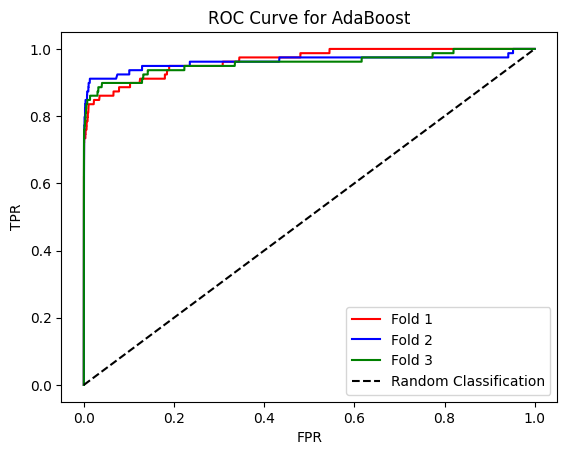

In [6]:
colors = ['r', 'b', 'g']
labels = ['Fold 1', 'Fold 2', 'Fold 3']

for fold in range(3):
    
    # build classifier 
    clf = AdaBoostClassifier(n_estimators=25, random_state=23)
    clf = clf.fit(d_train_df_X[fold], d_train_s_y[fold])
    
    y_hat_ab = clf.predict(d_test_df_X[fold])
    class_probs = clf.predict_proba(d_test_df_X[fold])
    fpr, tpr, thres = roc_curve(d_test_s_y[fold], class_probs[: , 1])
    
    # confusion matrix  
    tp = sum((y_hat_ab == 1) & (d_test_s_y[fold] == 1))
    tn = sum((y_hat_ab == 0) & (d_test_s_y[fold] == 0))
    fp = sum((y_hat_ab == 1) & (d_test_s_y[fold] == 0))
    fn = sum((y_hat_ab == 0) & (d_test_s_y[fold] == 1))
    
    # overall accuracy calculation 
    acc_ab[fold] = ( (tp + tn) / (tp + tn + fp + fn) )
    
    # overall tpr calculation 
    tpr_ab[fold] = (tp / (tp+fn))
    
    # overall ppv calculation 
    ppv_ab[fold] = (tp / (tp+fp))
     
    # overall fpr calculation 
    fpr_ab[fold] = (fp / (fp+tn))  
    
    # plot ROC curve
    plt.plot(fpr, tpr, color = colors[fold], label = labels[fold])

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for AdaBoost')
plt.plot([0,1], [0,1], '--', color = 'black', label = 'Random Classification')
plt.legend()

In [7]:
print('The min, mean, and max TPR are: {:.2f}, {:.2f}, and {:.2f}'.format(tpr_ab.min(), tpr_ab.mean(), tpr_ab.max()))
print('The min, mean, and max PPV are: {:.2f}, {:.2f}, and {:.2f}'.format(ppv_ab.min(), ppv_ab.mean(), ppv_ab.max()))
print('The min, mean, and max ACC are: {:.2f}, {:.2f}, and {:.2f}'.format(acc_ab.min(), acc_ab.mean(), acc_ab.max()))

The min, mean, and max TPR are: 0.62, 0.65, and 0.71
The min, mean, and max PPV are: 0.75, 0.79, and 0.82
The min, mean, and max ACC are: 1.00, 1.00, and 1.00


## Part 2: Random Forests 

Loop over the k folds using the dictionaries from above, and for each fold calculate the accuracy, TPR, the PPV, and the FPR. Plot the ROC curve for each fold.

Random Forest Parameters 
- criterion = 'entropy'
- max_features = 'sqrt'
- random_state = 23 

In [8]:
k = 3
acc_rf = np.zeros(k)
tpr_rf = np.zeros(k)
ppv_rf = np.zeros(k)
fpr_rf = np.zeros(k)

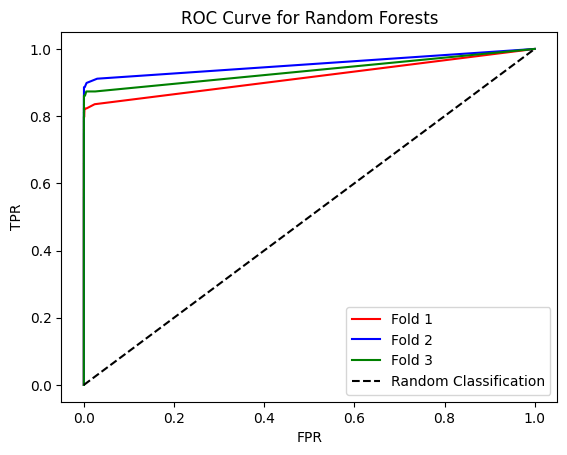

In [9]:
colors = ['r', 'b', 'g']
labels = ['Fold 1', 'Fold 2', 'Fold 3']

for fold in range(3):
    
    # build classifier 
    clf = RandomForestClassifier(criterion="entropy", max_features="sqrt", random_state=23)    
    clf = clf.fit(d_train_df_X[fold], d_train_s_y[fold])
    
    y_hat_rf = clf.predict(d_test_df_X[fold])
    class_probs = clf.predict_proba(d_test_df_X[fold])
    fpr, tpr, thres = roc_curve(d_test_s_y[fold], class_probs[: , 1])
    
    # confusion matrix  
    tp = sum((y_hat_ab == 1) & (d_test_s_y[fold] == 1))
    tn = sum((y_hat_ab == 0) & (d_test_s_y[fold] == 0))
    fp = sum((y_hat_ab == 1) & (d_test_s_y[fold] == 0))
    fn = sum((y_hat_ab == 0) & (d_test_s_y[fold] == 1))
    
    # overall accuracy calculation 
    acc_rf[fold] = ( (tp + tn) / (tp + tn + fp + fn) )
    
    # overall tpr calculation 
    tpr_rf[fold] = (tp / (tp+fn))
    
    # overall ppv calculation 
    ppv_rf[fold] = (tp / (tp+fp))
     
    # overall fpr calculation 
    fpr_rf[fold] = (fp / (fp+tn))  
    
    # plot ROC curve
    plt.plot(fpr, tpr, color = colors[fold], label = labels[fold])

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for Random Forests')
plt.plot([0,1], [0,1], '--', color = 'black', label = 'Random Classification')
plt.legend()

In [10]:
print('The min, mean, and max TPR are: {:.2f}, {:.2f}, and {:.2f}'.format(tpr_rf.min(), tpr_rf.mean(), tpr_rf.max()))
print('The min, mean, and max PPV are: {:.2f}, {:.2f}, and {:.2f}'.format(ppv_rf.min(), ppv_rf.mean(), ppv_rf.max()))
print('The min, mean, and max ACC are: {:.2f}, {:.2f}, and {:.2f}'.format(acc_rf.min(), acc_rf.mean(), acc_rf.max()))

The min, mean, and max TPR are: 0.00, 0.24, and 0.71
The min, mean, and max PPV are: 0.00, 0.27, and 0.80
The min, mean, and max ACC are: 1.00, 1.00, and 1.00


## Calculate the Cost of Fraud

Above, the predictions in the 3rd fold were saved into variables `y_hat_ab` and `y_hat_rf` for the AdaBoost and RandomForest models respectively. 

Calculate how much money will be saved by deploying either of these fraud algorithms to the real-time payment processing system, asssuming that there is not a currently deployed fraud detection algorithm.  

Rules: 
- For every fraudulent transaction that is not predicted as fraudulent, the bank looses twice the value of the transaction.  
- If a charge is predicted as fradulent, but wasn't, it costs the bank a flat fee of €3 in customer service support to communicate with the customer, and mark the possible fraud as a normal transaction. 

In [11]:
initialLoss = 0
adaboostLoss = 0
randomForestsLoss = 0

for idx in range(len(d_test_s_y[2])):
    actualC = d_test_s_y[2].values[idx]
    
    # no algorithm (initial) loss calculation 
    if actualC == 1:
        amount = d_train_df_X[2]['Amount'].values[idx]
        initialLoss += (amount*2)
    
    # adaboost loss calculation 
    adaboostPred = y_hat_ab[idx]
    if (actualC == 0) and (adaboostPred == 1):
        adaboostLoss += 3
    if (actualC == 1) and (adaboostPred == 0):
        amount = d_train_df_X[2]['Amount'].values[idx]
        adaboostLoss += (amount*2)
    
    # random forests loss calculation
    randomForestsPred = y_hat_rf[idx]
    if (actualC == 0) and (randomForestsPred == 1):
        randomForestsLoss += 3
    if (actualC == 1) and (randomForestsPred == 0):
        amount = d_train_df_X[2]['Amount'].values[idx]
        randomForestsLoss += (amount*2)

# savings calculations 
adaboostSavings = initialLoss - adaboostLoss
randomForestsSavings = initialLoss - randomForestsLoss

print('Savings with AdaBoost:', adaboostSavings)
print('Savings with Random Forests:', randomForestsSavings)

Savings with AdaBoost: 6314.199999999999
Savings with Random Forests: 7600.999999999999


In [ ]:
## Conclusion 
